# Exemplar Text Selection

Toponymy provides several methods for selecting exemplar texts that best represent the content of clusters. These exemplars serve as representative samples that will inform the LLM-prompt for a particular cluster or topic. This tutorial will explore the different exemplar selection methods available in Toponymy, their relative strengths and computational costs, and how to use them effectively.

Before we start, let's import the necessary libraries and load some data to work with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For this demonstration we'll use the ArXiv machine learning dataset, which contains titles and abstracts of machine learning papers from ArXiv. We'll just grab a single parquet file, comprising eighth of the full dataset, to get enough data to work with.

In [2]:
arxiv_ml_df = pd.read_parquet("hf://datasets/lmcinnes/arxiv_ml/data/train-00000-of-00008-f3c9b137f969d545.parquet")

As with other Toponymy workflows, we need both the high-dimensional embedding vectors and the lower-dimensional clusterable representation of our documents.

In [3]:
document_vectors = np.stack(arxiv_ml_df["embedding"].values)
clusterable_vectors = np.stack(arxiv_ml_df["data_map"].values)

In [4]:
document_vectors.shape

(35227, 768)

We'll need some topical clusters, ideally at a few resolutions, to select exemplars for. For that we'll just use the ToponymyClusterer so let's import it.

In [5]:
from toponymy.toponymy import ToponymyClusterer

First, let's create our cluster layers using the ToponymyClusterer. This will give us the cluster structure we need to select exemplars from.

In [6]:
layers, tree = ToponymyClusterer(verbose=True).fit_predict(clusterable_vectors=clusterable_vectors, embedding_vectors=document_vectors)

Layer 0 found 750 clusters
Layer 1 found 215 clusters
Layer 2 found 59 clusters
Layer 3 found 16 clusters


Now we can import the different exemplar selection methods available in Toponymy. The library provides several approaches with different trade-offs between quality and computational cost.

In [7]:
from toponymy.exemplar_texts import diverse_exemplars, random_exemplars, submodular_selection_exemplars

## Submodular Selection Methods

he most sophisticated approach to exemplar selection uses submodular optimization. Submodular functions have the property of diminishing returns, making them ideal for selecting diverse representative sets. Toponymy provides several submodular functions for exemplar selection, each with different characteristics.

Let's start with the facility location approach, which aims to select exemplars that minimize the maximum distance from any cluster member to its nearest selected exemplar.

In [8]:
%%time
fl_exemplars, fl_indices = submodular_selection_exemplars(
    layers[3].cluster_labels,
    arxiv_ml_df.title,
    document_vectors,
    n_exemplars=8,
    submodular_function="facility_location",
)

CPU times: user 18.9 s, sys: 1.05 s, total: 19.9 s
Wall time: 2 s


We successfully ran exemplar selection on all 16 clusters in the uppermost layer, and it took around two seconds. That may seem a little slow, but actually exemplar selection via submodular selection scales mostly with respect to the *size* of the clusters rather than the number of clusters, so the uppermost layer, with the largest clusters, is actually the more challenging task. For reference we can run exemplar selection on the 750 clusters in the lowest layer in about half the time:

In [9]:
%%time
submodular_selection_exemplars(
    layers[0].cluster_labels,
    arxiv_ml_df.title,
    document_vectors,
    n_exemplars=8,
    submodular_function="facility_location",
);

CPU times: user 983 ms, sys: 240 μs, total: 983 ms
Wall time: 982 ms


So we are expending computation time -- what are we getting for our trouble? Let's have a look at the exemplars picked for a couple of the clusters -- we can look at the same clusters for other exemplar selection methods for comparison -- and see whether they make sense.

In [10]:
fl_exemplars[0]

['On computing the Hermite form of a matrix of differential polynomials',
 'Gr\\"obner Bases over Algebraic Number Fields',
 'On the asymptotic and practical complexity of solving bivariate systems   over the reals',
 'Arrangement Computation for Planar Algebraic Curves',
 'A Symbolic Summation Approach to Feynman Integral Calculus',
 'Polynomial Systems Solving by Fast Linear Algebra',
 'Survey on counting special types of polynomials',
 'Differential elimination by differential specialization of Sylvester   style matrices']

In [11]:
fl_exemplars[15]

['The challenges of SVM optimization using Adaboost on a phoneme   recognition problem',
 'Dependent Hierarchical Normalized Random Measures for Dynamic Topic   Modeling',
 'Seeded Graph Matching',
 'Structured Learning via Logistic Regression',
 'Encoding Prior Knowledge with Eigenword Embeddings',
 'Multi Terminal Probabilistic Compressed Sensing',
 'Neural Network Influence in Group Technology: A Chronological Survey and   Critical Analysis',
 'Neyman-Pearson Classification under High-Dimensional Settings']

These look potentially reasonable. We have a mathematical topic related to the combination of linear algebra with polynomials in the first cluster. The second cluster seems quite broad, and the question is whether this is a poorly chosen sampling, or a good representation on the breadth of topics covered in the cluster. Hopefully we can get a better idea of that as we look at some of the other methods.

The saturated coverage approach is similar but uses a different objective function based on ensuring coverage by exemplars that can be quicker to compute for large clusters.

In [12]:
%%time
sc_exemplars, sc_indices = submodular_selection_exemplars(
    layers[3].cluster_labels,
    arxiv_ml_df.title,
    document_vectors,
    n_exemplars=8,
    submodular_function="saturated_coverage",
)

CPU times: user 17.6 s, sys: 2.24 s, total: 19.9 s
Wall time: 830 ms


We get faster results, but how well has it worked?

In [13]:
sc_exemplars[0]

['On computing the Hermite form of a matrix of differential polynomials',
 'On the Computation of Matrices of Traces and Radicals of Ideals',
 'Gr\\"obner Bases over Algebraic Number Fields',
 'Computing the decomposition group of a zero-dimensional ideal by   elimination method',
 'Computing solutions of linear Mahler equations',
 'Computing and Using Minimal Polynomials',
 'Note on fast division algorithm for polynomials using Newton iteration',
 'Polynomial Systems Solving by Fast Linear Algebra']

In [14]:
sc_exemplars[15]

['Minimax sparse principal subspace estimation in high dimensions',
 'Fast global convergence of gradient methods for high-dimensional   statistical recovery',
 'Regularizers for Structured Sparsity',
 'Optimal prediction for sparse linear models? Lower bounds for   coordinate-separable M-estimators',
 'Statistical consistency and asymptotic normality for high-dimensional   robust M-estimators',
 'Statistical and computational trade-offs in estimation of sparse   principal components',
 'Sparse PCA via Covariance Thresholding',
 'Convex vs nonconvex approaches for sparse estimation: GLasso, Multiple   Kernel Learning and Hyperparameter GLasso']

The first cluster again looks string, with the linear algebra and polynomial flavour coming through with some of the same examples picked. The second cluster starts to show the differences in these approaches. Again the exact nature of the cluster is clearly fuzzy (it is likely a large cluster), but the exemplars chosen by saturated coverage largely focus on statistical methods, giving a somewhat different impression than the fairly diverse examples provided by facility location selection. We'll get more sense of this cluster as we continue.

## Central Exemplars

For a faster alternative that still provides good diversity, Toponymy offers the diverse_exemplars function which takes exemplars close to the high dimensional centroid of the cluster and then seeks a diverse set from within those. The aim here is to get exemplars that capture the core idea or topic of the cluster, without having too much repetition. It is also a very fast to compute approach due to its simplicity.

In [15]:
%%time
d_exemplars, d_indices = diverse_exemplars(
    layers[3].cluster_labels,
    arxiv_ml_df.title,
    document_vectors,
    layers[3].centroid_vectors,
    n_exemplars=8,
)

CPU times: user 14.3 s, sys: 29.3 ms, total: 14.3 s
Wall time: 238 ms


This is clearly a fast method, and will scale well to very large cluster sizes and large numbers of clusters. How about the selection? We should expect more coherent looking exemplars as we can expect them to be focussed around the central subject of the cluster.

In [16]:
d_exemplars[0]

['Polynomial Systems Solving by Fast Linear Algebra',
 'Algorithms for Computing Triangular Decompositions of Polynomial Systems',
 'Constructive $D$-module Theory with \\textsc{Singular}',
 'On the Complexity of the Multivariate Resultant',
 'Real Polynomial Root-finding by Means of Matrix and Polynomial   Iterations',
 'Fast Computation of the Roots of Polynomials Over the Ring of Power   Series',
 'Critical Points and Gr\\"obner Bases: the Unmixed Case',
 'On the asymptotic and practical complexity of solving bivariate systems   over the reals']

In [17]:
d_exemplars[15]

['Fast Algorithms for Learning Latent Variables in Graphical Models',
 'High-Dimensional Covariance Decomposition into Sparse Markov and   Independence Models',
 'Statistical Query Lower Bounds for Robust Estimation of High-dimensional   Gaussians and Gaussian Mixtures',
 'Beyond L2-Loss Functions for Learning Sparse Models',
 'Group-Sparse Model Selection: Hardness and Relaxations',
 'Computationally Efficient Robust Estimation of Sparse Functionals',
 'Fast global convergence of gradient methods for high-dimensional   statistical recovery',
 'Noisy Matrix Completion under Sparse Factor Models']

As you can see we get a similar topic result for the first cluster, with a slightly different selection of specific examples. For the second cluster we get something perhaps closer to the saturated coverage selection with a general trend toward statistical methods, but no clear organizing principle. Perhaps the cluster it just quite varied? We can definitely get a sense of that with the last, and fastest selection method: random sampling.

## Random Selection

The simplest and fastest approach is random selection of exemplars from each cluster. While this doesn't guarantee quality or diversity, it can be useful for quick exploration or if a large number of exemplars are required, or you simply need to scale to truly large data.

In [18]:
%%time
r_exemplars, r_indices = random_exemplars(
    layers[3].cluster_labels,
    arxiv_ml_df.title,
    n_exemplars=8,
)

CPU times: user 1.11 s, sys: 4 μs, total: 1.11 s
Wall time: 17.7 ms


As expected, random selection is extremely fast and will also scale well with the number of exemplars requested (where the other methods will tend to be a little slower). This also gives us a chance to see what kinds of things these clusters actually contain.

In [19]:
r_exemplars[0]

['Parallel computation of the rank of large sparse matrices from algebraic   K-theory',
 'Symbolic-numeric methods for improving structural analysis of   differential-algebraic equation systems',
 "Hrushovski's Algorithm for Computing the Galois Group of a Linear   Differential Equation",
 'Exact Symbolic-Numeric Computation of Planar Algebraic Curves',
 'Survey on counting special types of polynomials',
 'Obtaining Exact Interpolation Multivariate Polynomial by Approximation',
 'Power Series Composition and Change of Basis',
 'Generating Loop Invariants by Computing Vanishing Ideals of Sample   Points']

In [20]:
r_exemplars[15]

["Total Variation and Euler's Elastica for Supervised Learning",
 'hi-RF: Incremental Learning Random Forest for large-scale multi-class   Data Classification',
 'Linear Spatial Pyramid Matching Using Non-convex and non-negative Sparse   Coding for Image Classification',
 'Mind the Nuisance: Gaussian Process Classification using Privileged   Noise',
 'A New Measure of Conditional Dependence',
 'Ranking and combining multiple predictors without labeled data',
 'Learning Boolean functions with concentrated spectra',
 'Learning sparse gradients for variable selection and dimension reduction']

For the first cluster we can see the mathematical flavour favoured by the more careful selection methods certainly holds true, but given a small random selection it is clear that the cluster is reasonably diverse. For the second cluster we see the focus on statistical methods may not be entirely representative: there are a lot of general learning approaches here, from clustering, to boosted trees, alogn with statistcal approaches.

We can take a larger random sample to see this more clearly:

In [21]:
%%time
r_exemplars, _ = random_exemplars(
    layers[3].cluster_labels,
    arxiv_ml_df.title,
    n_exemplars=32,
)

CPU times: user 939 ms, sys: 469 μs, total: 939 ms
Wall time: 15.1 ms


In [22]:
r_exemplars[0]

['Matrix Formula of Differential Resultant for First Order Generic   Ordinary Differential Polynomials',
 'On the computation of the straight lines contained in a rational surface',
 'Generic design of Chinese remaindering schemes',
 'A Note on the Space Complexity of Fast D-Finite Function Evaluation',
 'The Invar tensor package: Differential invariants of Riemann',
 'Partial Denominator Bounds for Partial Linear Difference Equations',
 'Harmonic Sums and Polylogarithms Generated by Cyclotomic Polynomials',
 'Gr\\"obner Bases for Linearized Polynomials',
 'Divide-And-Conquer Computation of Cylindrical Algebraic Decomposition',
 'Real root finding for determinants of linear matrices',
 "Zeilberger's Holonomic Ansatz for Pfaffians",
 'Factorization in categories of systems of linear partial differential   equations',
 'Computing necessary integrability conditions for planar parametrized   homogeneous potentials',
 'GPGCD, an Iterative Method for Calculating Approximate GCD of Univariate

In [23]:
r_exemplars[15]

['Onsager-corrected deep learning for sparse linear inverse problems',
 'A characterization of product-form exchangeable feature probability   functions',
 'Bayesian Inference Based on Stationary Fokker-Planck Sampling',
 'A concentration inequality for the excess risk in least-squares   regression with random design and heteroscedastic noise',
 'A Nonconvex Approach for Structured Sparse Learning',
 'Bayesian SPLDA',
 'The Laplacian K-modes algorithm for clustering',
 'A Slice Sampler for Restricted Hierarchical Beta Process with   Applications to Shared Subspace Learning',
 'Robust Probabilistic Modeling with Bayesian Data Reweighting',
 'Quantile universal threshold: model selection at the detection edge for   high-dimensional linear regression',
 'Out-of-sample generalizations for supervised manifold learning for   classification',
 'Graph-based Generalization Bounds for Learning Binary Relations',
 'General Scaled Support Vector Machines',
 'Jitter-Adaptive Dictionary Learning - A

With a larger sample we see that while the mathematical cluster is more general than polynomials and linear algebra, that is a reasonable representation of the core of the topic. On the other hand the second cluster remains extremely diverse, and likely about general classical machine learning techniques in general rather than any specific subfield.

## Visualizing the selections

To see what is going on with the exemplar selections it can be helpful to provide some visualizations. While the actual selections were making use of high dimensional vectors, we also have the low dimensional representations used for clustering. We can look at the clusters in this representation and overlay the different selections to see what kinds of exemplars are being picked out by the different methods. For this we'll need matplotlib.

In [24]:
import matplotlib.pyplot as plt

Let's start with the cluster that was providing confusing results -- the second cluster which two of the methods leaned toward statistical methods, while the facility location and random selection gave far more diverse results. 

[[], []]

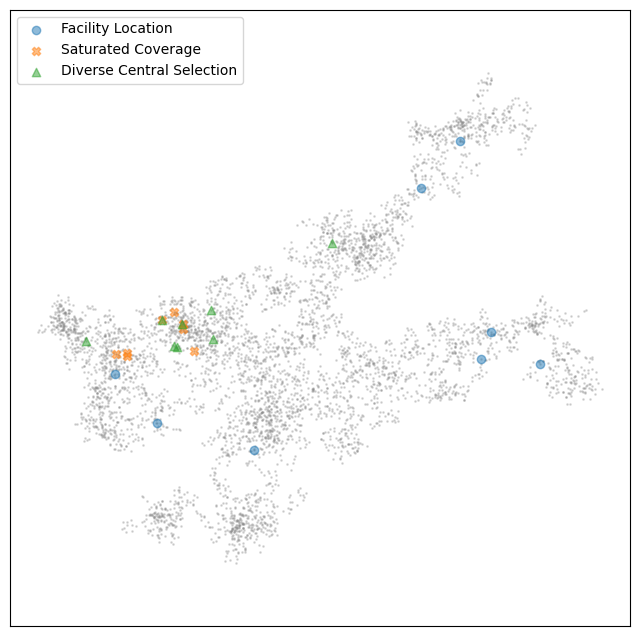

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*clusterable_vectors[layers[3].cluster_labels == 15].T, s=1, c="gray", alpha=0.25)
ax.scatter(*clusterable_vectors[fl_indices[15]].T, marker="o", label="Facility Location", alpha=0.5)
ax.scatter(*clusterable_vectors[sc_indices[15]].T, marker="X", label="Saturated Coverage", alpha=0.5)
ax.scatter(*clusterable_vectors[d_indices[15]].T, marker="^", label="Diverse Central Selection", alpha=0.5)
ax.axis('equal')
ax.legend()
ax.set(xticks=[], yticks=[])

As you can see, the cluster is quite large, with a few different branching subtopics spreading out from the center. The central selection approach, and the saturated coverage, tended to focus on the more central regions of the cluster, while the facility location selection picked out items from some of the branching arms as being representative of the cluster as a whole. This has the benefit of providing a more representative overall sample, but has the downside of providing a less coherent overall topic.

Now let's examine the linear algebra and polynomials cluster ...

[[], []]

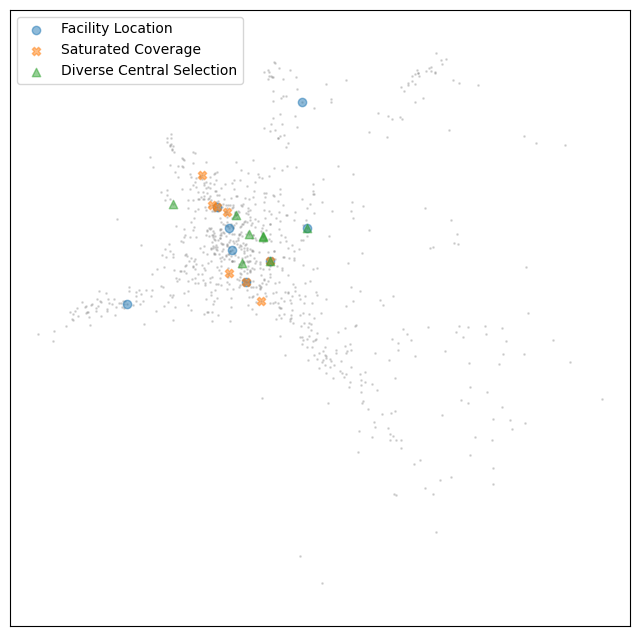

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*clusterable_vectors[layers[3].cluster_labels == 0].T, s=1, c="gray", alpha=0.25)
ax.scatter(*clusterable_vectors[fl_indices[0]].T, marker="o", label="Facility Location", alpha=0.5)
ax.scatter(*clusterable_vectors[sc_indices[0]].T, marker="X", label="Saturated Coverage", alpha=0.5)
ax.scatter(*clusterable_vectors[d_indices[0]].T, marker="^", label="Diverse Central Selection", alpha=0.5)
ax.axis('equal')
ax.legend()
ax.set(xticks=[], yticks=[])

We can see why this cluster was more easy to select exemplars from -- while it has some outlying topics, there really is a single core topic, and significantly fewer points overall which makes it much easier to cleanly represent with a small number of exemplars. None the less we have a similar result with the facility location managing to select a few outlying points representing some of those branching satellite subjects, while the other methods remain focused on the core.

Let's look at a few more cluster to ensure we are getting the right intuitions about how these techniques work.

[[], []]

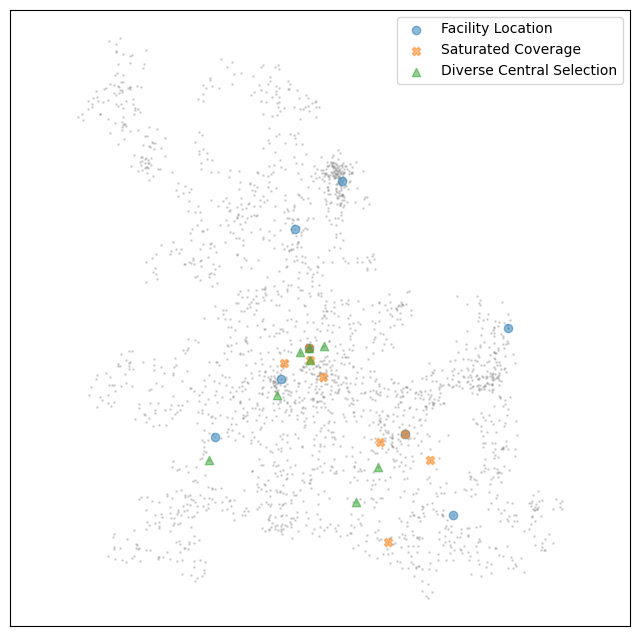

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*clusterable_vectors[layers[3].cluster_labels == 6].T, s=1, c="gray", alpha=0.25)
ax.scatter(*clusterable_vectors[fl_indices[6]].T, marker="o", label="Facility Location", alpha=0.5)
ax.scatter(*clusterable_vectors[sc_indices[6]].T, marker="X", label="Saturated Coverage", alpha=0.5)
ax.scatter(*clusterable_vectors[d_indices[6]].T, marker="^", label="Diverse Central Selection", alpha=0.5)
ax.axis('equal')
ax.legend()
ax.set(xticks=[], yticks=[])

[[], []]

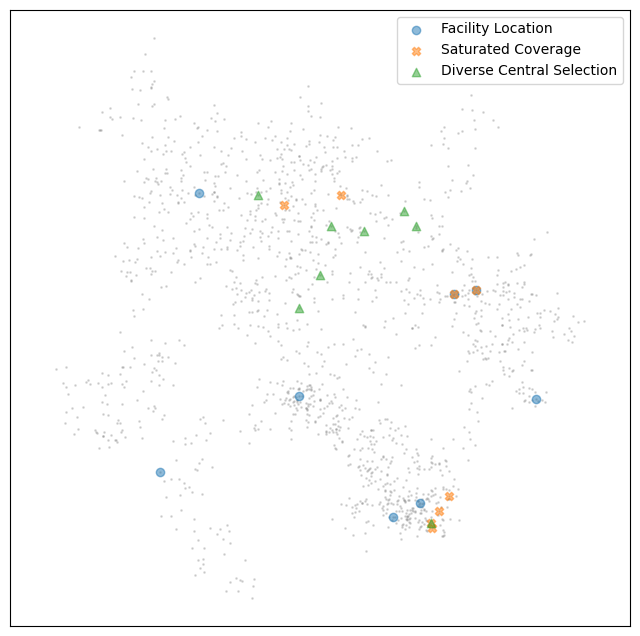

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*clusterable_vectors[layers[3].cluster_labels == 8].T, s=1, c="gray", alpha=0.25)
ax.scatter(*clusterable_vectors[fl_indices[8]].T, marker="o", label="Facility Location", alpha=0.5)
ax.scatter(*clusterable_vectors[sc_indices[8]].T, marker="X", label="Saturated Coverage", alpha=0.5)
ax.scatter(*clusterable_vectors[d_indices[8]].T, marker="^", label="Diverse Central Selection", alpha=0.5)
ax.axis('equal')
ax.legend()
ax.set(xticks=[], yticks=[])

The general trend seems pretty clear. So, when selection what exemplar method to use you should consider what you most want from your exemplars: a coherent central topic that is easier for the LLM to label, but perhaps not as representative of the full diversity of the cluster? Then central selection or saturated coverage should work well. If you want to ensure the diversity of the cluster makes it to the LLM then facility location is a good choice. Lastly you may need to alter your choice depending on your computation time and scaling needs. Hopefully this walkthrough has provided enough information to help you make informed choices.